In [1]:
import nest_asyncio
nest_asyncio.apply()
import stan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("LockeLowell.csv")

In [3]:
print(df)

      t_date  t_numeric
0    1/23/00       0.00
1    1/26/00       2.58
2     2/3/00      10.89
3     2/9/00      16.14
4    2/23/00      30.21
5    2/27/00      34.60
6    2/28/00      35.76
7     3/6/00      42.63
8    3/11/00      47.62
9    6/16/00     144.38
10   6/25/00     153.79
11   6/30/00     158.63
12   7/13/00     172.09
13   7/30/00     188.12
14   7/31/00     189.63
15   8/16/00     206.06
16   9/13/00     233.96
17   5/31/01     493.71
18    6/7/01     501.02
19   6/17/01     510.27
20   6/26/01     520.04
21   6/29/01     523.00
22  11/18/01     664.26
23   12/6/01     683.09
24   5/13/02     840.97


In [4]:
df.head()
# df.shape
# df.columns
df['t_date'] = pd.to_datetime(df['t_date'])
days = (df['t_date'].iloc[-1] - df['t_date'].iloc[0]).days
print(days)

841


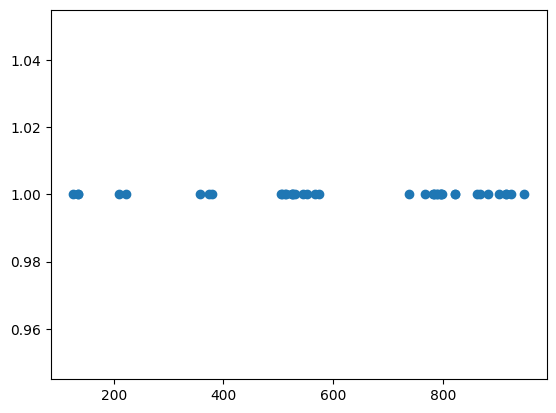

In [5]:
gamma=0.10936016909654006
R0=0.5531935628364816
mu=0.015528078784962346
T=3 * 365

times=[]
N=np.random.poisson(mu*T)

for i in range(N):
  times.append(T*np.random.rand())

cnt=0
while(cnt<N):
  
  for i in range(cnt,N):
    M=np.random.poisson(R0)
    cnt+=1
    for j in range(M):
      tnew=times[i]+np.random.exponential(1./gamma)
      if(tnew<T):
        times.append(tnew)
        N+=1


times=np.sort(times)

z=np.ones(times.shape)
plt.scatter(times,z)

In [6]:
model_code = """
data {
  int N;
  real t[N];
  int T;
}
parameters {
  real<lower=0> gamma;
  real<lower=0,upper=1> R;
  real<lower=0> mu;
}
transformed parameters {
  vector[N] lam;

  lam[1] = mu;
  
  for (j in 2:N){
    lam[j]=mu;
    for(k in 1:(j-1)){
     lam[j] = lam[j]+R*gamma*exp(-gamma*(t[j]-t[k]));
    }
  }
}
model {
  R ~ beta(1,1);
  mu ~ exponential(.1);
  gamma ~ exponential(.1);
  for (j in 1:N){
    target+=log(lam[j]);
  }
  target+=-mu*T-R*N;
}
"""

In [7]:
# make t_numeric into a python list
t_numeric = df['t_numeric'].tolist()

In [8]:
data = {'N': len(t_numeric), 't': t_numeric, 'T': days}
posterior = stan.build(model_code, data=data, random_seed=2)
fit = posterior.sample(num_chains=1, num_samples=1000)



Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/64/7cc975tn74sb3dg4ztck8zsw0000gn/T/httpstan_ajuzqsof/model_ob6maid5.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:  15% (300/2000)
Sampling:  30% (600/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 0.000529 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.29 seconds.
  Adjust your expectations accordingly!


In [9]:
print("R_0: ", np.mean(fit['R']))
print("R_0 var: ",np.var(fit['R'])**.5)

#plt.plot(fit['lam'])

R_0:  0.5531935628364816
R_0 var:  0.19441513120821965


In [10]:
print("Gamma: ", np.mean(fit['gamma']))
print("Gamma var: ", np.var(fit['gamma'])**.5)

Gamma:  0.10936016909654006
Gamma var:  0.10234810796568136


In [11]:
print("Mu: ",np.mean(fit['mu']))
print("Mu var:", np.var(fit['mu'])**.5)

Mu:  0.015528078784962346
Mu var: 0.006148784290065306
